# Face Mask Detection

## Make Experiment 

In [5]:
import mlflow
import os


os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("Facemask-Detection1")

<Experiment: artifact_location='file:///d:/facemask/mlruns/862957065725366956', creation_time=1744497316647, experiment_id='862957065725366956', last_update_time=1744497316647, lifecycle_stage='active', name='Facemask-Detection1', tags={}>

## Class Distribution Analysis

In [6]:
import os
from collections import Counter

class_names = ["improper_mask", "no_mask", "proper_mask"]
label_dirs = ["train/labels", "valid/labels"]
class_counts = Counter()

for d in label_dirs:
    for file in os.listdir(d):
        if file.endswith(".txt"):
            with open(os.path.join(d, file)) as f:
                class_counts.update(int(line.split()[0]) for line in f if line.strip())

for i, name in enumerate(class_names):
    print(f"{name}: {class_counts.get(i, 0)} instances")


improper_mask: 2740 instances
no_mask: 3401 instances
proper_mask: 3261 instances


## Class Distribution Visualization


In [7]:
import os
from collections import Counter
import matplotlib.pyplot as plt

class_names = ["improper_mask", "no_mask", "proper_mask"]
label_dirs = ["train/labels", "valid/labels"]
class_counts = Counter()

for d in label_dirs:
    for file in os.listdir(d):
        if file.endswith(".txt"):
            with open(os.path.join(d, file)) as f:
                class_counts.update(int(line.split()[0]) for line in f if line.strip())

counts = [class_counts.get(i, 0) for i in range(len(class_names))]
with mlflow.start_run(run_name="class_distribution"):   
    plt.bar(class_names, counts, color=['orange', 'red', 'green'])
    plt.title("Class Distribution in Mask Dataset")
    plt.xlabel("Class")
    plt.ylabel("Instances")

    plot_path = "class_distribution.png"
    plt.tight_layout()
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    plt.close()


## Sample Images per Class

In [8]:
import  random
import matplotlib.patches as patches
from PIL import Image


names = ["improper_mask", "no_mask", "proper_mask"]
imgs, lbls = "train/images", "train/labels"
chosen = {}

for f in random.sample(os.listdir(lbls), len(os.listdir(lbls))):
    if f.endswith(".txt"):
        ids = {int(l.split()[0]) for l in open(os.path.join(lbls, f))}
        for cid in ids:
            if cid not in chosen: chosen[cid] = f.replace(".txt", ".jpg")
    if len(chosen) == 3: break

with mlflow.start_run(run_name="sample_per_class"):
    for cid, img_file in chosen.items():
        img = Image.open(os.path.join(imgs, img_file))
        w, h = img.size
        fig, ax = plt.subplots(); ax.imshow(img)
        with open(os.path.join(lbls, img_file.replace(".jpg", ".txt"))) as f:
            for l in f:
                id_, x, y, bw, bh = map(float, l.split())
                if int(id_) != cid: continue
                rect = patches.Rectangle(((x - bw/2)*w, (y - bh/2)*h), bw*w, bh*h,
                                         edgecolor='r', facecolor='none', lw=2)
                ax.add_patch(rect)
                ax.text((x - bw/2)*w, (y - bh/2)*h, names[int(id_)], color='w',
                        fontsize=8, bbox=dict(facecolor='r', alpha=0.5))
        plt.axis('off')
        out = f"sample_{names[cid]}.png"
        plt.savefig(out, bbox_inches='tight'); mlflow.log_artifact(out); plt.close()


## Image Size Distribution

In [9]:
import os
from PIL import Image

image_dirs = ["train/images", "valid/images"]

widths, heights = [], []

for img_dir in image_dirs:
    for file in os.listdir(img_dir):
        if file.endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(img_dir, file)
            with Image.open(img_path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)

with mlflow.start_run(run_name="image_size_distribution"):
    plt.figure(figsize=(10, 5))
    plt.hist(widths, bins=20, alpha=0.7, label='Widths', color='skyblue')
    plt.hist(heights, bins=20, alpha=0.7, label='Heights', color='salmon')
    plt.title("Image Size Distribution")
    plt.xlabel("Pixels")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()

    plot_path = "image_size_distribution.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    plt.close()


## Class Co-Occurrence Heatmap

In [10]:
import  numpy as np, seaborn as sns

class_names = ["improper_mask", "no_mask", "proper_mask"]
co_matrix = np.zeros((3, 3), dtype=int)

for d in ["train/labels", "valid/labels"]:
    for f in os.listdir(d):
        if f.endswith(".txt"):
            with open(os.path.join(d, f)) as file:
                labels = sorted(set(int(line.split()[0]) for line in file))
                for i in labels:
                    for j in labels:
                        co_matrix[i][j] += 1

with mlflow.start_run(run_name="class_cooccurrence_heatmap"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(co_matrix, xticklabels=class_names, yticklabels=class_names,
                annot=True, fmt="d", cmap="YlOrBr")
    plt.title("Class Co-Occurrence Heatmap")
    plt.tight_layout()
    plt.savefig("co_heatmap.png")
    mlflow.log_artifact("co_heatmap.png")
    plt.close()


## Train and Save Model 

In [11]:
mlflow.end_run()


In [12]:
from ultralytics import YOLO
import os
import mlflow
import pandas as pd

model_name = "yolov8n.pt"
project_name = "models"
experiment_name = "Facemask-Detection1"
run_name = "YOLOv8_train_face_mask"
epochs = 8
imgsz = 640
batch_size = 16
data_path = "D:/facemask/data.yaml"


mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name):

    mlflow.log_params({
        "model": model_name,
        "epochs": epochs,
        "imgsz": imgsz,
        "batch_size": batch_size,
        
    })

    model = YOLO(model_name)
    model.train(
        data=data_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch_size,
        name="face_mask",
        project=project_name
    )

    best_model_path = f"{project_name}/facemask/weights/best.pt"
    if os.path.exists(best_model_path):
        mlflow.log_artifact(best_model_path)

    results = model.val()
    metrics = results.box  
    mlflow.log_metrics({
    "precision": sum(metrics.p) / len(metrics.p),
    "recall": sum(metrics.r) / len(metrics.r),
    "mAP50": sum(metrics.ap50) / len(metrics.ap50),
    "mAP50-95": sum(metrics.ap) / len(metrics.ap)
    })


    if os.path.exists(data_path):
        mlflow.log_artifact(data_path)


    for img in ["results.png", "confusion_matrix.png"]:
        path = os.path.join(project_name, "yolov8_face_mask", img)
        if os.path.exists(path):
            mlflow.log_artifact(path)

    results_csv_path = os.path.join("runs", "train", "yolov8_face_mask", "results.csv")
    if os.path.exists(results_csv_path):
        df = pd.read_csv(results_csv_path)
        last_row = df.iloc[-1]
        mlflow.log_metrics({
            "train_box_loss": last_row["train/box_loss"],
            "train_cls_loss": last_row["train/cls_loss"],
            "train_dfl_loss": last_row["train/dfl_loss"],
            "val_box_loss": last_row["val/box_loss"],
            "val_cls_loss": last_row["val/cls_loss"],
            "val_dfl_loss": last_row["val/dfl_loss"]
        })

print("Training completed and all metrics  have been logged to MLflow.")


New https://pypi.org/project/ultralytics/8.3.108 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.107  Python-3.12.4 torch-2.6.0+cpu CPU (Intel Core(TM) i7-7700HQ 2.80GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/facemask/data.yaml, epochs=8, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=models, name=face_mask, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save

train: Scanning D:\facemask\train\labels.cache... 3582 images, 21 backgrounds, 0 corrupt: 100%|██████████| 3582/3582 [00:00<?, ?it/s]
val: Scanning D:\facemask\valid\labels.cache... 337 images, 1 backgrounds, 0 corrupt: 100%|██████████| 337/337 [00:00<?, ?it/s]

Plotting labels to models\face_mask\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
MLflow: logging run_id(b5379ff0190e4247bdd56e1a3c20b5ae) to file:./mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to models\face_mask
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8         0G      1.506      2.731       1.59        116        640:  31%|███▏      | 70/224 [11:46<25:54, 10.09s/it] 


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import os

results_path = r"D:/facemask/models/face_mask5/results.csv"
experiment_name = "Facemask-Detection1"
run_name = "results for first model befor retraining"
artifact_path = "plots"

mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name):

    df = pd.read_csv(results_path)
    df.index = df.index + 1  

    metrics = df.columns[2:12]  

    plt.figure(figsize=(18, 8))
    for i, col in enumerate(metrics):
        plt.subplot(2, 5, i+1)
        plt.plot(df.index, df[col], label="results", marker='o')
        plt.plot(df.index, df[col].rolling(window=3, min_periods=1).mean(), 'orange', linestyle='dotted', label="smooth")
        plt.title(col)
        plt.legend()

    plt.tight_layout()

    # حفظ 
    os.makedirs("outputs", exist_ok=True)
    plot_path = "outputs/results_plot.png"
    plt.savefig(plot_path)
    plt.close()

    mlflow.log_artifact(plot_path, artifact_path)

    
    print(" ✅")


 ✅


In [ ]:
import os
import mlflow
import pandas as pd
from ultralytics import YOLO

mlflow.set_experiment("Facemask-Detection1")

model_path = "models/face_mask5/weights/best.pt"
data_path = "D:/facemask/data.yaml"  

with mlflow.start_run(run_name="YOLOv8 Validation Only"):
    model = YOLO(model_path)

    results = model.val(data=data_path, imgsz=640, batch=2, device="cpu")

    metrics = results.box
    mlflow.log_metrics({
        "precision": sum(metrics.p) / len(metrics.p),
        "recall": sum(metrics.r) / len(metrics.r),
        "mAP50": sum(metrics.ap50) / len(metrics.ap50),
        "mAP50-95": sum(metrics.ap) / len(metrics.ap)
    })

    
    if os.path.exists(model_path):
        mlflow.log_artifact(model_path)

    if os.path.exists(data_path):
        mlflow.log_artifact(data_path)

    for img in ["results.png", "confusion_matrix.png"]:
        if os.path.exists(img):
            mlflow.log_artifact(img)

print("✅ Validation completed and results logged to MLflow.")


Ultralytics 8.3.107  Python-3.12.4 torch-2.6.0+cpu CPU (Intel Core(TM) i7-7700HQ 2.80GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\facemask\valid\labels.cache... 337 images, 1 backgrounds, 0 corrupt: 100%|██████████| 337/337 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:56<00:00,  2.97it/s]


                   all        337        963      0.916      0.853      0.922      0.616
         improper_mask        228        232      0.987      0.944      0.984      0.833
               no_mask         89        406      0.918      0.795      0.887        0.5
           proper_mask         74        325      0.844      0.819      0.894      0.516
Speed: 2.3ms preprocess, 121.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\val4
✅ Validation completed and results logged to MLflow.


In [ ]:
import os
import mlflow
import pandas as pd
from ultralytics import YOLO

model_path = "models/face_mask5/weights/best.pt"
data_path = "D:/facemask/data.yaml"  
project_name = "models"
mlflow.set_experiment("Facemask-Detection1")
with mlflow.start_run(run_name="Continue_YOLOv8_Evaluation"):
    model = YOLO(model_path)
    results = model.val()
    metrics = results.box  
    
    mlflow.log_metrics({
        "precision": sum(metrics.p) / len(metrics.p),
        "recall": sum(metrics.r) / len(metrics.r),
        "mAP50": sum(metrics.ap50) / len(metrics.ap50),
        "mAP50-95": sum(metrics.ap) / len(metrics.ap)
    })

    if os.path.exists(data_path):
        mlflow.log_artifact(data_path)

    for img in ["results.png", "confusion_matrix.png"]:
        path = os.path.join(project_name, "yolov8_face_mask", img)
        if os.path.exists(path):
            mlflow.log_artifact(path)

    results_csv_path = os.path.join("runs", "train", "yolov8_face_mask", "results.csv")
    if os.path.exists(results_csv_path):
        df = pd.read_csv(results_csv_path)
        last_row = df.iloc[-1]
        mlflow.log_metrics({
            "train_box_loss": last_row["train/box_loss"],
            "train_cls_loss": last_row["train/cls_loss"],
            "train_dfl_loss": last_row["train/dfl_loss"],
            "val_box_loss": last_row["val/box_loss"],
            "val_cls_loss": last_row["val/cls_loss"],
            "val_dfl_loss": last_row["val/dfl_loss"]
        })


Ultralytics 8.3.107  Python-3.12.4 torch-2.6.0+cpu CPU (Intel Core(TM) i7-7700HQ 2.80GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\facemask\valid\labels.cache... 337 images, 1 backgrounds, 0 corrupt: 100%|██████████| 337/337 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:57<00:00,  2.60s/it]


                   all        337        963      0.916      0.853      0.922      0.616
         improper_mask        228        232      0.987      0.944      0.984      0.833
               no_mask         89        406      0.918      0.795      0.887        0.5
           proper_mask         74        325      0.844      0.819      0.894      0.516
Speed: 3.0ms preprocess, 115.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\val5


## Continue Training Model 

In [ ]:
mlflow.end_run()

In [ ]:
from ultralytics import YOLO
import os
import mlflow
import pandas as pd

model_name = "models/face_mask5/weights/best.pt"
project_name = "models"
experiment_name = "Facemask-Detection1"
run_name = "YOLOv8_finetune_v2"
epochs = 4
imgsz = 640
batch_size = 16
data_path = "D:/facemask/data.yaml"

#mlflow.set_tracking_uri("http://127.0.0.1:5000") 
mlflow.set_experiment(experiment_name)  

with mlflow.start_run(run_name=run_name):

    mlflow.log_params({
        "model": model_name,
        "epochs": epochs,
        "imgsz": imgsz,
        "batch_size": batch_size,
    })

    model = YOLO(model_name)
    model.train(
        data=data_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch_size,
        name="yolov8_face_mask",  
        project=project_name
    )

    best_model_path = f"{project_name}/yolov8_face_mask/weights/best.pt"
    if os.path.exists(best_model_path):
        mlflow.log_artifact(best_model_path)

    results = model.val()
    metrics = results.box
    mlflow.log_metrics({
        "precision": sum(metrics.p) / len(metrics.p),
        "recall": sum(metrics.r) / len(metrics.r),
        "mAP50": sum(metrics.ap50) / len(metrics.ap50),
        "mAP50-95": sum(metrics.ap) / len(metrics.ap)
    })

    if os.path.exists(data_path):
        mlflow.log_artifact(data_path)

    for img in ["results.png", "confusion_matrix.png"]:
        path = os.path.join(project_name, "yolov8_face_mask", img)
        if os.path.exists(path):
            mlflow.log_artifact(path)

    results_csv_path = os.path.join("runs", "train", "yolov8_face_mask", "results.csv")
    if os.path.exists(results_csv_path):
        df = pd.read_csv(results_csv_path)
        last_row = df.iloc[-1]
        mlflow.log_metrics({
            "train_box_loss": last_row["train/box_loss"],
            "train_cls_loss": last_row["train/cls_loss"],
            "train_dfl_loss": last_row["train/dfl_loss"],
            "val_box_loss": last_row["val/box_loss"],
            "val_cls_loss": last_row["val/cls_loss"],
            "val_dfl_loss": last_row["val/dfl_loss"]
        })

print("✅ Training completed and all metrics have been logged to MLflow.")


Ultralytics 8.3.107  Python-3.12.4 torch-2.6.0+cpu CPU (Intel Core(TM) i7-7700HQ 2.80GHz)
engine\trainer: task=detect, mode=train, model=models/face_mask5/weights/best.pt, data=D:/facemask/data.yaml, epochs=4, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=models, name=yolov8_face_mask2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

train: Scanning D:\facemask\train\labels.cache... 3582 images, 21 backgrounds, 0 corrupt: 100%|██████████| 3582/3582 [00:00<?, ?it/s]
val: Scanning D:\facemask\valid\labels.cache... 337 images, 1 backgrounds, 0 corrupt: 100%|██████████| 337/337 [00:00<?, ?it/s]


Plotting labels to models\yolov8_face_mask2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
MLflow: logging run_id(814c6806c40943cfa05dd12d4358bc00) to file:./mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to models\yolov8_face_mask2
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/4         0G     0.9986     0.6489      1.163         42        640: 100%|██████████| 224/224 [42:00<00:00, 11.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [02:00<00:00, 10.91s/it]

                   all        337        963      0.891      0.837       0.91      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/4         0G      1.031     0.7069      1.185         46        640: 100%|██████████| 224/224 [34:00<00:00,  9.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:05<00:00,  5.97s/it]

                   all        337        963       0.88      0.836      0.895       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/4         0G      1.021     0.6884      1.181         78        640: 100%|██████████| 224/224 [28:58<00:00,  7.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:02<00:00,  5.70s/it]

                   all        337        963      0.908       0.83      0.901      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/4         0G     0.9816     0.6213      1.163         72        640: 100%|██████████| 224/224 [28:29<00:00,  7.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:02<00:00,  5.72s/it]

                   all        337        963      0.887      0.873      0.922      0.606



4 epochs completed in 2.313 hours.
Optimizer stripped from models\yolov8_face_mask2\weights\last.pt, 6.2MB
Optimizer stripped from models\yolov8_face_mask2\weights\best.pt, 6.2MB

Validating models\yolov8_face_mask2\weights\best.pt...
Ultralytics 8.3.107  Python-3.12.4 torch-2.6.0+cpu CPU (Intel Core(TM) i7-7700HQ 2.80GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:51<00:00,  4.64s/it]


                   all        337        963      0.887      0.873      0.922      0.606
         improper_mask        228        232      0.979      0.944      0.985      0.806
               no_mask         89        406      0.884      0.823      0.892      0.499
           proper_mask         74        325      0.798      0.853       0.89      0.512
Speed: 4.6ms preprocess, 133.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to models\yolov8_face_mask2
MLflow: results logged to file:./mlruns
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.107  Python-3.12.4 torch-2.6.0+cpu CPU (Intel Core(TM) i7-7700HQ 2.80GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\facemask\valid\labels.cache... 337 images, 1 backgrounds, 0 corrupt: 100%|██████████| 337/337 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:40<00:00,  1.86s/it]


                   all        337        963      0.887      0.873      0.922      0.606
         improper_mask        228        232      0.979      0.944      0.985      0.806
               no_mask         89        406      0.884      0.823      0.892      0.499
           proper_mask         74        325      0.798      0.853       0.89      0.512
Speed: 2.4ms preprocess, 106.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to models\yolov8_face_mask22
✅ Training completed and all metrics have been logged to MLflow.


In [ ]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

model = YOLO('D:/facemask/models/yolov8_face_mask2/weights/best.pt')   

results = model('D:/facemask/test/images/12_Group_Group_12_Group_Group_12_36_jpg.rf.e990d876cd77395e5dd6849b7ecf1714.jpg')  

results[0].show() 

#results[0].save(save_dir='predictions/')  


image 1/1 D:\facemask\test\images\12_Group_Group_12_Group_Group_12_36_jpg.rf.e990d876cd77395e5dd6849b7ecf1714.jpg: 640x640 20 no_masks, 1 proper_mask, 132.1ms
Speed: 3.2ms preprocess, 132.1ms inference, 71.5ms postprocess per image at shape (1, 3, 640, 640)




image 1/1 D:\facemask\test\images\maksssksksss131_png.rf.4faa44fdf623b8bc1abac6bdcb85427a.jpg: 640x640 2 no_masks, 4 proper_masks, 160.7ms
image 1/1 D:\facemask\test\images\maksssksksss131_png.rf.4faa44fdf623b8bc1abac6bdcb85427a.jpg: 640x640 2 no_masks, 4 proper_masks, 160.7ms
Speed: 6.1ms preprocess, 160.7ms inference, 98.0ms postprocess per image at shape (1, 3, 640, 640)
Speed: 6.1ms preprocess, 160.7ms inference, 98.0ms postprocess per image at shape (1, 3, 640, 640)


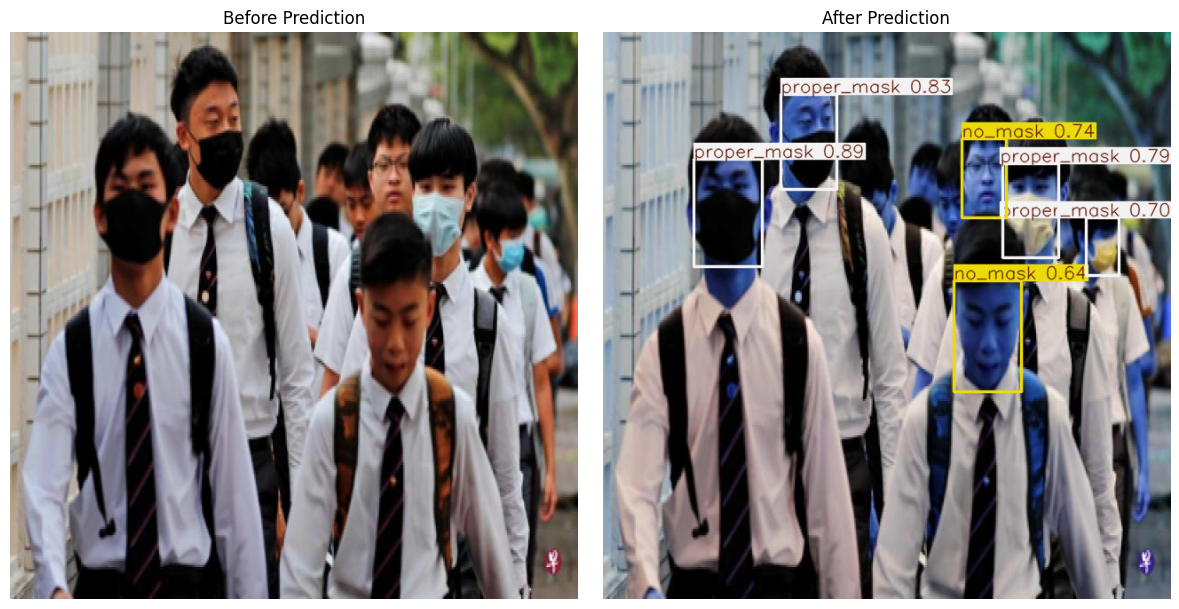

In [ ]:


import cv2
import matplotlib.pyplot as plt

img_path = 'D:/facemask/test/images/maksssksksss131_png.rf.4faa44fdf623b8bc1abac6bdcb85427a.jpg'  

original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

model_path = 'D:/facemask/models/yolov8_face_mask2/weights/best.pt'  
model = YOLO(model_path)

results = model(img_path)

predicted_img = results[0].plot()  
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Before Prediction')
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('After Prediction')
plt.imshow(predicted_img)
plt.axis('off')

plt.tight_layout()
plt.show()


In [2]:
import cv2
from ultralytics import YOLO

model_path = 'D:/facemask/models/face_mask5/weights/best.pt'  
model = YOLO(model_path)

cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)
    annotated_frame = results[0].plot()
    cv2.imshow("YOLOv8 Detection - iVCam", annotated_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


0: 480x640 (no detections), 115.2ms
Speed: 3.5ms preprocess, 115.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 178.2ms
Speed: 5.0ms preprocess, 178.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 136.9ms
Speed: 4.4ms preprocess, 136.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 103.5ms
Speed: 2.3ms preprocess, 103.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 103.8ms
Speed: 2.5ms preprocess, 103.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 102.3ms
Speed: 2.2ms preprocess, 102.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 106.4ms
Speed: 2.4ms preprocess, 106.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 106.1ms
Speed: 2.5ms prepr

In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import io
import numpy as np
import mlflow
from ultralytics import YOLO

img_path = 'D:/facemask/test/images/maksssksksss131_png.rf.4faa44fdf623b8bc1abac6bdcb85427a.jpg'
model_path = 'D:/facemask/models/yolov8_face_mask2/weights/best.pt'

original_img = cv2.imread(img_path)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

model = YOLO(model_path)

with mlflow.start_run(run_name="YOLOv8 Face Mask Prediction"):
    results = model(img_path)
    predicted_img = results[0].plot()

    orig_pil = Image.fromarray(original_img_rgb)
    mlflow.log_image(orig_pil, "before_prediction.png")

    pred_pil = Image.fromarray(predicted_img)
    mlflow.log_image(pred_pil, "after_prediction.png")



image 1/1 D:\facemask\test\images\maksssksksss131_png.rf.4faa44fdf623b8bc1abac6bdcb85427a.jpg: 640x640 2 no_masks, 4 proper_masks, 140.0ms
Speed: 4.7ms preprocess, 140.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


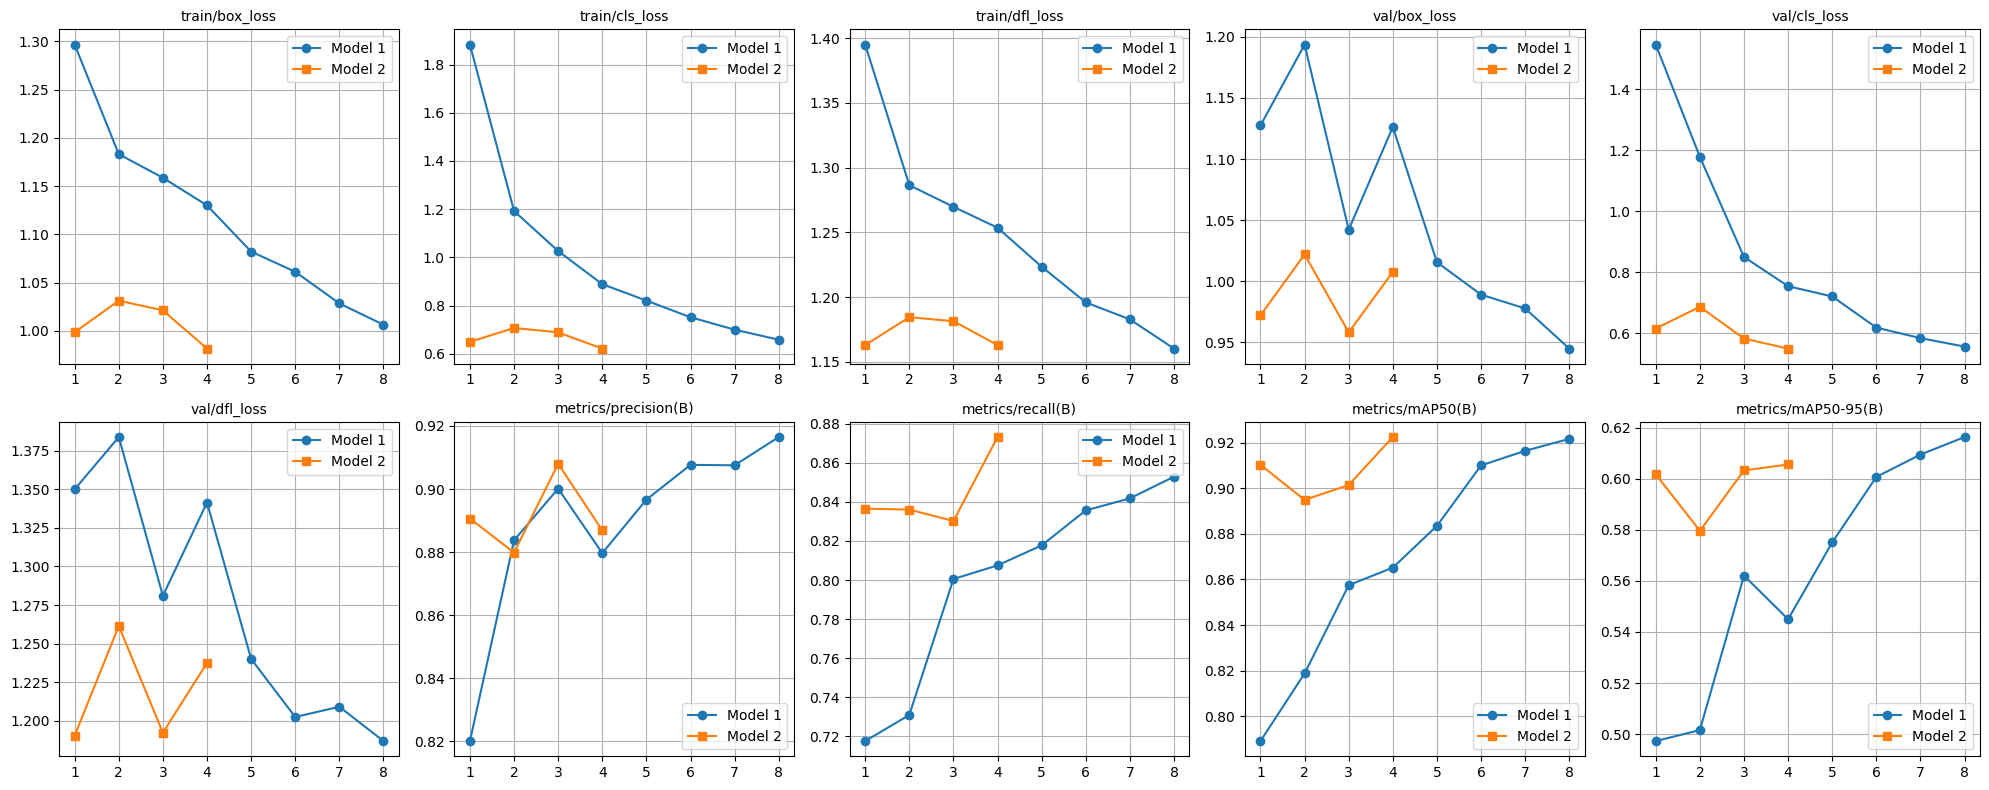

✅ Logged comparison plot to MLflow: model_comparison.png


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

csv_modelbeforretraining = r"D:/facemask/models/face_mask5/results.csv"  
csv_modelafterretraining = r"D:/facemask/models/yolov8_face_mask2/results.csv"

df1 = pd.read_csv(csv_modelbeforretraining)
df2 = pd.read_csv(csv_modelafterretraining)

metrics_to_plot = [
    "train/box_loss", "train/cls_loss", "train/dfl_loss",
    "val/box_loss", "val/cls_loss", "val/dfl_loss",
    "metrics/precision(B)", "metrics/recall(B)", 
    "metrics/mAP50(B)", "metrics/mAP50-95(B)"
]




with mlflow.start_run(run_name="Comparison_Plots-a-b-training"):

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        axes[i].plot(df1['epoch'], df1[metric], label="Model 1", marker='o')
        axes[i].plot(df2['epoch'], df2[metric], label="Model 2", marker='s')
        axes[i].set_title(metric, fontsize=10)
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    comparison_plot_path = "model_comparison.png"
    plt.savefig(comparison_plot_path)
    plt.show()


    mlflow.log_artifact(comparison_plot_path)
    print(f"✅ Logged comparison plot to MLflow: {comparison_plot_path}")
